In [1]:
!pip install datasets transformers evaluate

In [2]:
import torch.nn as nn
from torch.utils.data import DataLoader
import math
from tqdm import tqdm
from datasets import load_dataset, DatasetDict
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import matplotlib.pyplot as plt
from evaluate import load as load_metric
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

In [3]:
# ===== 2. Load Dataset =====
dataset = load_dataset("csebuetnlp/xlsum", "indonesian")
train_data = dataset['train'].shuffle(seed=42).select(range(500))
val_data = dataset['validation'].shuffle(seed=42).select(range(200))
test_data = dataset['test'].shuffle(seed=42).select(range(200))
dataset = DatasetDict({
    "train": train_data,
    "validation": val_data,
    "test": test_data
})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(train_data[0])

{'id': '150408_irak_isis_yazidi', 'url': 'https://www.bbc.com/indonesia/dunia/2015/04/150408_irak_isis_yazidi', 'title': 'ISIS membebaskan penganut Yazidi', 'summary': 'Kelompok militan yang menamakan diri Negara Islam atau ISIS dilaporkan membebaskan sekitar 227 orang sekte Yazidi yang selama ini menjadi tawanan mereka.', 'text': "Bulan Januari lalu, militan ISIS membebaskan anggota sekte Yazidi yang mereka tahan. Diketahui bahwa mereka yang dilepaskan adalah orang-orang yang sudah berusia lanjut atau dalam keadaan sakit. Komandan pasukan Kurdi, Westa Rasul, menyatakan beberapa di antara yang dilepaskan adalah 'wanita dan anak-anak'. Puluhan ribu penganut sekte Yazidi dipaksa untuk mengungsi ketika ISIS menyerbu desa-desa mereka pada bulan Agustus tahun lalu. Ribuan dari mereka mengungsi hingga ke gunung-gunung di Irak utara. Kelompok militan ini mengutuk keimanan sekte Yazidi dan membunuh ratusan anggota komunitas ini. Perserikatan Bangsa-bangsa menyatakan kemungkinan bahwa ISIS mela

In [5]:
model_name = "Wikidepia/IndoT5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    inputs = ["summarize: " + " ".join(doc) for doc in examples["text"]]
    targets = examples["summary"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Tokenisasi target (summary)
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenisasi dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
print(tokenized_datasets['train'][0])
print(tokenized_datasets['validation'][0])
print(tokenized_datasets['test'][0])

{'id': '150408_irak_isis_yazidi', 'url': 'https://www.bbc.com/indonesia/dunia/2015/04/150408_irak_isis_yazidi', 'title': 'ISIS membebaskan penganut Yazidi', 'summary': 'Kelompok militan yang menamakan diri Negara Islam atau ISIS dilaporkan membebaskan sekitar 227 orang sekte Yazidi yang selama ini menjadi tawanan mereka.', 'text': "Bulan Januari lalu, militan ISIS membebaskan anggota sekte Yazidi yang mereka tahan. Diketahui bahwa mereka yang dilepaskan adalah orang-orang yang sudah berusia lanjut atau dalam keadaan sakit. Komandan pasukan Kurdi, Westa Rasul, menyatakan beberapa di antara yang dilepaskan adalah 'wanita dan anak-anak'. Puluhan ribu penganut sekte Yazidi dipaksa untuk mengungsi ketika ISIS menyerbu desa-desa mereka pada bulan Agustus tahun lalu. Ribuan dari mereka mengungsi hingga ke gunung-gunung di Irak utara. Kelompok militan ini mengutuk keimanan sekte Yazidi dan membunuh ratusan anggota komunitas ini. Perserikatan Bangsa-bangsa menyatakan kemungkinan bahwa ISIS mela

Melakukan generate ringkasan dari base model wikidepia/indoT5

In [7]:
# ===== 4. Load Model =====
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [8]:
# ===== 5. Prepare DataLoader =====
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True)
val_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=8)
test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)

In [9]:
# ===== 6. Generate Summaries =====
def generate_summary(texts):
    inputs = tokenizer(["summarize: " + text for text in texts], return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Generate summaries
    outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128, num_beams=4, early_stopping=True)
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# Test generation on validation data
# Access the original 'text' from the dataset:
sample_texts = [dataset["validation"][i]["text"] for i in range(5)]
generated_summaries = generate_summary(sample_texts)

for i, (text, summary) in enumerate(zip(sample_texts, generated_summaries)):
    print(f"Original Text {i+1}:\n{text}\n")
    print(f"Generated Summary {i+1}:\n{summary}\n")

Original Text 1:
Perusahaan penyelenggara ulang tahun anak-anak mengatakan, biaya yang dikeluarkan untuk pesta sangat mahal Namun, permintaan semacam itu benar-benar diajukan salah seorang klien perusahaan event organizer bernama Quintessentially Events & Weddings. Pada sebuah musim dingin, perusahaan ini menciptakan tema luar ruangan di dalam ruangan untuk pesta ulang tahun anak-anak. Dengan tema itu, perusahaan tersebut menanam rumput dalam ruangan, lengkap dengan pohon-pohon, bunga, ayunan dan peluncur. Menurut manajer Chloe Astin, mereka mematok harga 100.000 pound atau setara dengan Rp1,9 miliar. Harga itu mencakup makanan kecil untuk orang dewasa, tas pesta, dan suvenir berupa kalung Tiffany kecil untuk anak-anak. Inflasi Dengan kondisi ekonomi saat ini yang diwarnai inflasi, kemeriahan pesta ulang tahun tidak menunjukkan tanda-tanda penurunan. Anak saya baru berusia lima tahun, tapi ia sudah menghadiri pesta ultah dalam berbagai tema. Sebut saja sesi pembuatan pizza di dapur res

In [10]:
# ===== 7. Evaluate with BLEU Score =====
def calculate_bleu(references, candidates):
    bleu_scores = []
    for ref, cand in zip(references, candidates):
        bleu_scores.append(sentence_bleu([ref.split()], cand.split()))
    return np.mean(bleu_scores)

# Extract references and candidates from the validation set
# Access the 'summary' from the original dataset, not the tokenized one:
references = [dataset["validation"][i]["summary"] for i in range(20)]
candidates = generate_summary([dataset["validation"][i]["text"] for i in range(20)])

# Calculate BLEU Score
bleu_score = calculate_bleu(references, candidates)
print(f"BLEU Score on Validation Set: {bleu_score:.4f}")

BLEU Score on Validation Set: 0.0000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

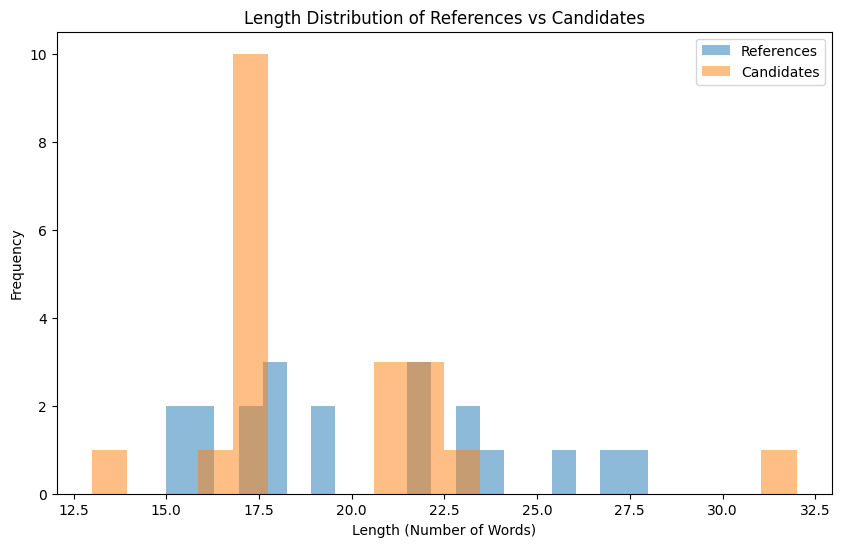

In [11]:
# ===== 8. Plot Results =====
plt.figure(figsize=(10, 6))
plt.hist([len(text.split()) for text in references], bins=20, alpha=0.5, label="References")
plt.hist([len(text.split()) for text in candidates], bins=20, alpha=0.5, label="Candidates")
plt.title("Length Distribution of References vs Candidates")
plt.xlabel("Length (Number of Words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Finetune dengan model wikidepia/indoT5

In [12]:
!pip install sacrebleu

In [13]:
# ===== 9. Define Model and Training Arguments =====
from transformers import EarlyStoppingCallback
from evaluate import load as load_metric

model = T5ForConditionalGeneration.from_pretrained(model_name)

training_args = TrainingArguments(
    output_dir="./indoT5_summarization_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    gradient_checkpointing=True,
    logging_steps=500,  # Track metrics during training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
# ===== 10. Train the Model =====
train_results = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: algha_naufal (algha_naufal-universitas-pendidikan-indonesia). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,No log,46.599133
2,No log,44.591942
3,No log,43.514381


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


In [15]:
# ===== 11. Evaluation =====
from evaluate import load as load_metric  # Import the load function if not already imported

# Load the BLEU metric
metric = load_metric("bleu")  # Load the metric before using it

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = np.array(pred.predictions[0]).argmax(-1)  # Ambil elemen pertama dari tuple, lalu ubah menjadi array numpy dan panggil argmax
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # BLEU computation
    references = [[label] for label in label_str]
    predictions = pred_str
    bleu = metric.compute(predictions=predictions, references=references)
    return {"bleu": bleu["bleu"]}

# Run Evaluation
predictions = trainer.predict(tokenized_datasets["test"])
eval_metrics = compute_metrics(predictions)
print("BLEU Score:", eval_metrics["bleu"])

BLEU Score: 0.020580579584793184


In [16]:
# Plotting the training accuracy (BLEU score) over epochs
def plot_training_accuracy(log_file):
    with open(log_file, 'r') as f:
        lines = f.readlines()

    # Extract BLEU score values from the log
    bleu_scores = []
    for line in lines:
        if "bleu" in line:
            score = float(line.split("bleu")[-1].split()[0])
            bleu_scores.append(score)

    # Plotting BLEU score
    plt.plot(bleu_scores, label="BLEU Score")
    plt.xlabel("Epoch")
    plt.ylabel("BLEU Score")
    plt.title("BLEU Score per Epoch during Training")
    plt.legend()
    plt.show()

In [17]:
# Additional Evaluation on BLEU Scores
def compute_bleu(predicted, reference):
    reference = [ref.split() for ref in reference]
    predicted = predicted.split()
    return sentence_bleu(reference, predicted)

test_data = tokenized_datasets["test"]
trainer = Trainer(model=model)
predictions = trainer.predict(test_data)

predictions_array = predictions.predictions[0]
predicted_ids = predictions_array.argmax(axis=-1)
decoded_preds = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

labels_array = predictions.label_ids
decoded_labels = tokenizer.batch_decode(labels_array, skip_special_tokens=True)

# Store BLEU scores
bleu_scores = []
num_samples = 5

for i in range(num_samples):
    input_text = test_data[i]["text"]
    actual_summary = decoded_labels[i]
    predicted_summary = decoded_preds[i]

    bleu_score = compute_bleu(predicted_summary, [actual_summary])
    bleu_scores.append(bleu_score)

    print(f"Data {i+1}:")
    print(f"Input Asli: {input_text}")
    print(f"Actual Summary: {actual_summary}")
    print(f"Predicted Summary: {predicted_summary}")
    print(f"BLEU Score: {bleu_score}")
    print("-" * 50)

# Calculate average BLEU score
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu_score:.4f}")

Data 1:
Input Asli: Pandemi Covid-19 telah meningkatkan minat berinvestasi emas. Kenaikan harga itu salah satu penyebab utamanya karena permainan para pedagang emas dan permintaan yang tinggi, tapi di balik itu, muncul pertanyaan tentang berapa sisa pasokan logam mulia itu di bumi dan kapan akan habis. Emas menjadi buruan masyarakat karena dapat dijadikan sebagai investasi, simbol status ekonomi, dan komponen utama produk elektronik. Tapi jumlah emas di dunia terbatas, dan pada akhirnya akan datang satu saat ketika tidak ada lagi emas yang tersisa untuk ditambang. Puncak produksi emas Beberapa ahli berbicara tentang apakah dunia telah mencapai puncak produksi emas - diukur dengan jumlah terbanyak emas yang pernah ditambang dalam satu tahun - atau tidak. Hal itu ditunjukan dengan mulai menurunnya tren produksi emas dunia. Contohnya, pada tahun 2019, produksi tambang emas dunia turun 1% menjadi 3.531 ton dibandingkan tahun 2018, menurut Dewan Emas Dunia. Penurunan produksi tahunan ini ya

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [18]:
# ===== 11. Evaluate and Generate Summaries =====
def generate_summary(texts):
    inputs = tokenizer(["summarize: " + text for text in texts], return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)

    # Generate summaries
    outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128, num_beams=4, early_stopping=True)
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# Test generation on validation data
# Access the 'text' from the original dataset:
sample_texts = [dataset["validation"][i]["text"] for i in range(5)] # Change to access original dataset
generated_summaries = generate_summary(sample_texts)

for i, (text, summary) in enumerate(zip(sample_texts, generated_summaries)):
    print(f"Original Text {i+1}:\n{text}\n")
    print(f"Generated Summary {i+1}:\n{summary}\n")

Original Text 1:
Perusahaan penyelenggara ulang tahun anak-anak mengatakan, biaya yang dikeluarkan untuk pesta sangat mahal Namun, permintaan semacam itu benar-benar diajukan salah seorang klien perusahaan event organizer bernama Quintessentially Events & Weddings. Pada sebuah musim dingin, perusahaan ini menciptakan tema luar ruangan di dalam ruangan untuk pesta ulang tahun anak-anak. Dengan tema itu, perusahaan tersebut menanam rumput dalam ruangan, lengkap dengan pohon-pohon, bunga, ayunan dan peluncur. Menurut manajer Chloe Astin, mereka mematok harga 100.000 pound atau setara dengan Rp1,9 miliar. Harga itu mencakup makanan kecil untuk orang dewasa, tas pesta, dan suvenir berupa kalung Tiffany kecil untuk anak-anak. Inflasi Dengan kondisi ekonomi saat ini yang diwarnai inflasi, kemeriahan pesta ulang tahun tidak menunjukkan tanda-tanda penurunan. Anak saya baru berusia lima tahun, tapi ia sudah menghadiri pesta ultah dalam berbagai tema. Sebut saja sesi pembuatan pizza di dapur res

In [19]:
# ===== 12. Evaluate with BLEU Score =====
def calculate_bleu(references, candidates):
    bleu_scores = []
    for ref, cand in zip(references, candidates):
        bleu_scores.append(sentence_bleu([ref.split()], cand.split()))
    return np.mean(bleu_scores)

# Extract references and candidates from the validation set
# Access 'summary' from the original dataset, not the tokenized one:
references = [dataset["validation"][i]["summary"] for i in range(len(tokenized_datasets["validation"][:100]))]  # Get summaries from the original dataset
candidates = generate_summary([dataset["validation"][i]["text"] for i in range(len(tokenized_datasets["validation"][:100]))])  # Get texts from the original dataset

# Calculate BLEU Score
bleu_score = calculate_bleu(references, candidates)
print(f"BLEU Score on Validation Set: {bleu_score:.4f}")

# Calculate ROUGE Scores
# Assuming rouge_metric is defined somewhere else in your code
try:
    rouge_scores = rouge_metric.compute(predictions=candidates, references=references)
    print("ROUGE Scores on Validation Set:")
    for key, value in rouge_scores.items():
        print(f"{key}: {value:.4f}")
except NameError:
    print("rouge_metric is not defined. Please define it before calculating ROUGE scores.")

BLEU Score on Validation Set: 0.0000
rouge_metric is not defined. Please define it before calculating ROUGE scores.


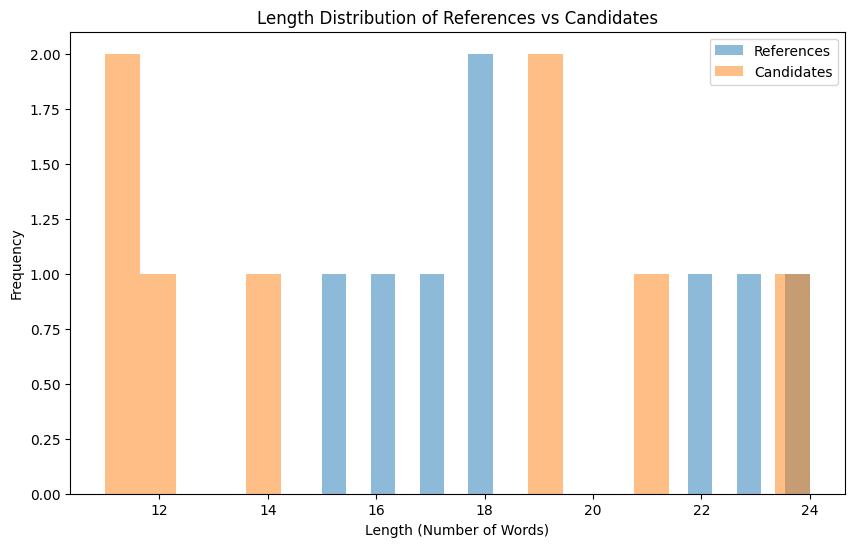

In [20]:
# ===== 13. Plot Results =====
plt.figure(figsize=(10, 6))
plt.hist([len(text.split()) for text in references], bins=20, alpha=0.5, label="References")
plt.hist([len(text.split()) for text in candidates], bins=20, alpha=0.5, label="Candidates")
plt.title("Length Distribution of References vs Candidates")
plt.xlabel("Length (Number of Words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

melakukan dengan LLM lain

In [21]:
from transformers import AutoTokenizer, Phi3ForCausalLM
import torch

checkpoint = "microsoft/Phi-3.5-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
model = Phi3ForCausalLM.from_pretrained(
    checkpoint,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto"
)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
sample_article = dataset["train"][0]["text"]
sample_summary = dataset["train"][0]["summary"]
sample_article1 = dataset["train"][1]["text"]
sample_summary1 = dataset["train"][1]["summary"]

one shot

In [23]:
sample_article = dataset["train"][0]["text"]
sample_summary = dataset["train"][0]["summary"]
new_article = dataset["test"][1]["text"]

prompt = f"""
Below is an example of summarization:
Article: {sample_article}
Summary: {sample_summary}

Now, summarize the following article:
Article: {new_article}
Summary:"""

inputs = tokenizer(prompt, return_tensors="pt")
generate_ids = model.generate(inputs.input_ids, max_new_tokens=50, num_beams=5, early_stopping=True)
generated_summary = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print("New Article:\n", new_article)
print("\nGenerated Summary:\n", generated_summary)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:2134: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


New Article:
 Murray unggul dalam 8 pertandingan dengan Lopez Petenis Inggris itu sudah delapan kali bertemu Lopez dan menang di semua pertandingan. Kini dengan disaksikan mantan pelatihnya Ivan Lendl, ia mencetak kemenangan kesembilan. Murray mengalahkan Lopez, unggulan ke-32, dengan 6-4 6-1 dalam waktu 73 menit. Di babak berikutnya ia akan bertemu dengan unggulan ke-11 Jo-Wilfried Tsonga. Sementara itu Roger Federer mengalahkan petenis Belanda Thiemo de Bakker dengan 6-3 6-3. Murray menunjukkan performa kuat di hadapan Lendl, yang hanya empat hari setelah pengumuman perpisahan mereka, terbang tiga jam dari Florida ke Miami untuk melihat petenis yang telah ia bantu menjuarai Olimpiade, AS Terbuka dan Wimbledon. "Kami kembali bersama. Kami hanya berpisah selama empat hari," kelakar Murray. "Tidak, sayang sekali ia tidak akan lagi menyaksikan pertandingan saya secara langsung."

Generated Summary:
 
Below is an example of summarization:
Article: Bulan Januari lalu, militan ISIS membebas

few shot

In [24]:
sample_article1 = dataset["train"][1]["text"]
sample_summary1 = dataset["train"][1]["summary"]

prompt = f"""
Below is an example of summarization:
Article: {sample_article}
Summary: {sample_summary}
Article: {sample_article1}
Summary: {sample_summary1}

Now, summarize the following article:
Article: {new_article}
Summary:"""

inputs = tokenizer(prompt, return_tensors="pt")
generate_ids = model.generate(inputs.input_ids, max_new_tokens=50, num_beams=5, early_stopping=True)
generated_summary = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print("New Article:\n", new_article)
print("\nGenerated Summary:\n", generated_summary)

New Article:
 Murray unggul dalam 8 pertandingan dengan Lopez Petenis Inggris itu sudah delapan kali bertemu Lopez dan menang di semua pertandingan. Kini dengan disaksikan mantan pelatihnya Ivan Lendl, ia mencetak kemenangan kesembilan. Murray mengalahkan Lopez, unggulan ke-32, dengan 6-4 6-1 dalam waktu 73 menit. Di babak berikutnya ia akan bertemu dengan unggulan ke-11 Jo-Wilfried Tsonga. Sementara itu Roger Federer mengalahkan petenis Belanda Thiemo de Bakker dengan 6-3 6-3. Murray menunjukkan performa kuat di hadapan Lendl, yang hanya empat hari setelah pengumuman perpisahan mereka, terbang tiga jam dari Florida ke Miami untuk melihat petenis yang telah ia bantu menjuarai Olimpiade, AS Terbuka dan Wimbledon. "Kami kembali bersama. Kami hanya berpisah selama empat hari," kelakar Murray. "Tidak, sayang sekali ia tidak akan lagi menyaksikan pertandingan saya secara langsung."

Generated Summary:
 
Below is an example of summarization:
Article: Bulan Januari lalu, militan ISIS membebas

In [25]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk  # Import the nltk library

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

reference_summary = dataset["test"][1]["summary"]

def calculate_bleu_score(reference, candidate):
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    smoothing = SmoothingFunction().method4
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothing)

bleu_score = calculate_bleu_score(reference_summary, generated_summary)
print(f"\nBLEU Score: {bleu_score:.4f}")


BLEU Score one shot: 0.0026


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


LLM lain with fine tune

In [1]:
import torch
from transformers import AutoTokenizer, TrainingArguments, Trainer, pipeline
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset, DatasetDict
from nltk.translate.bleu_score import sentence_bleu
import gc

In [2]:
# ===== 2. Load Dataset =====
dataset = load_dataset("csebuetnlp/xlsum", "indonesian")
train_data = dataset['train'].shuffle(seed=42).select(range(100))
val_data = dataset['validation'].shuffle(seed=42).select(range(100))
test_data = dataset['test'].shuffle(seed=42).select(range(100))
dataset = DatasetDict({
    "train": train_data,
    "validation": val_data,
    "test": test_data
})
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 100
    })
})


In [3]:
sample_article = dataset["train"][0]["text"]
sample_summary = dataset["train"][0]["summary"]
sample_article1 = dataset["train"][1]["text"]
sample_summary1 = dataset["train"][1]["summary"]
new_article = dataset["test"][1]["text"]

In [4]:
# ===== 2. Load Model and Tokenizer =====
model_name = "microsoft/Phi-3.5-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Load Model
from transformers import Phi3ForCausalLM

model = Phi3ForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
)

# Cek model architecture untuk mengetahui nama layer
print(model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3SdpaAttention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): Phi3RMSNorm((3072,)

In [16]:
# ===== 3. Apply LoRA Configuration =====
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj'],  # Adjusted based on architecture
)
model = get_peft_model(model, lora_config)
model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): Phi3ForCausalLM(
          (model): Phi3Model(
            (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
            (embed_dropout): Dropout(p=0.0, inplace=False)
            (layers): ModuleList(
              (0-31): 32 x Phi3DecoderLayer(
                (self_attn): Phi3SdpaAttention(
                  (o_proj): lora.Linear(
                    (base_layer): Linear(in_features=3072, out_features=3072, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=3072, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=3072, bias=False)
                    )

In [6]:
!pip install trl

In [25]:
def preprocess_function(examples):
    inputs = examples["text"]
    targets = examples["summary"]
    # Tokenize the inputs
    model_inputs = tokenizer(
        inputs,
        max_length=512,  # Ensure consistent max_length with training
        truncation=True,
        padding="max_length",
    )
    # Tokenize the labels
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=512,  # Match input max_length
            truncation=True,
            padding="max_length",
        )
    # Replace pad token with -100 for labels
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]
    # Ensure labels have the same length as inputs
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

In [26]:
!pip install accelerate

In [27]:
# ===== 5. Training Arguments =====
training_args = TrainingArguments(
    output_dir="./phi3-liputan6-summarizer-lora",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=500,
    fp16=True,
    gradient_checkpointing=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
train_tokenized_datasets = train_data.map(
    preprocess_function,
    batched=True,
    remove_columns=train_data.column_names
)
val_tokenized_datasets = val_data.map(
    preprocess_function,
    batched=True,
    remove_columns=val_data.column_names
)

# Ensure batch size is a divisor of dataset length
train_batch_size = training_args.per_device_train_batch_size * max(1, torch.cuda.device_count())
eval_batch_size = training_args.per_device_eval_batch_size * max(1, torch.cuda.device_count())

train_length = len(train_tokenized_datasets)
eval_length = len(val_tokenized_datasets)

train_tokenized_datasets = train_tokenized_datasets.select(range(train_length - (train_length % train_batch_size)))
val_tokenized_datasets = val_tokenized_datasets.select(range(eval_length - (eval_length % eval_batch_size)))

# Double-check your LoraConfig
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['qkv_proj', 'o_proj'],  # Verify these are the correct modules
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [29]:
# Debugging tensor shapes
for batch in train_tokenized_datasets:
    print("Input IDs shape:", len(batch["input_ids"]))
    print("Labels shape:", len(batch["labels"]))

Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labels shape: 512
Input IDs shape: 512
Labe

In [30]:
trainer = Trainer(
    model=model,
    train_dataset=train_tokenized_datasets,
    eval_dataset=val_tokenized_datasets,
    # peft_config=lora_config,
    tokenizer=tokenizer,
    args=training_args
)

<ipython-input-30-d18d4ff0eba0>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,8.007912
2,No log,6.686430
3,No log,6.578727


TrainOutput(global_step=150, training_loss=8.544259440104167, metrics={'train_runtime': 340.165, 'train_samples_per_second': 0.882, 'train_steps_per_second': 0.441, 'total_flos': 3439426063564800.0, 'train_loss': 8.544259440104167, 'epoch': 3.0})

In [37]:
# ===== 6. Inference (One-Shot and Few-Shot) =====
summarization_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Contoh teks untuk dirangkum
test_text = (
    "Presiden Jokowi mengumumkan kebijakan baru terkait subsidi bahan bakar minyak. Kebijakan ini diambil untuk "
    "mengurangi beban fiskal negara yang semakin meningkat akibat lonjakan harga minyak dunia. Pemerintah "
    "berjanji akan mengalokasikan dana subsidi untuk sektor yang lebih produktif seperti pendidikan dan kesehatan."
)

# Summary yang diharapkan (untuk evaluasi)
expected_summary = (
    "Presiden Jokowi mengumumkan subsidi bahan bakar akan dialihkan untuk pendidikan dan kesehatan demi "
    "mengurangi beban fiskal negara."
)

# ===== One-Shot Learning =====
# Membuat prompt untuk one-shot
one_shot_prompt = f"""Below is an example of summarization:
Article: {sample_article}
Summary: {sample_summary}

Now, summarize the following article:
Article: {test_text}
Summary:"""

# Melakukan inference untuk one-shot
one_shot_summary = summarization_pipeline(one_shot_prompt, max_new_tokens=50, min_length=20, do_sample=False)

# Menampilkan hasil
print("\n===== One-Shot Learning =====")
print("\nOriginal Article:\n")
print(test_text)
print("\nExpected Summary:\n")
print(expected_summary)
print("\nGenerated Summary:\n")
print(one_shot_summary[0]['generated_text'].replace(one_shot_prompt, ""))

Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianFor


===== One-Shot Learning =====

Original Article:

Presiden Jokowi mengumumkan kebijakan baru terkait subsidi bahan bakar minyak. Kebijakan ini diambil untuk mengurangi beban fiskal negara yang semakin meningkat akibat lonjakan harga minyak dunia. Pemerintah berjanji akan mengalokasikan dana subsidi untuk sektor yang lebih produktif seperti pendidikan dan kesehatan.

Expected Summary:

Presiden Jokowi mengumumkan subsidi bahan bakar akan dialihkan untuk pendidikan dan kesehatan demi mengurangi beban fiskal negara.

Generated Summary:

 Jok diumkanananananananananananananananananananananananananananananananananananananananananananananan


In [38]:
# ===== Few-Shot Learning =====
# Membuat prompt untuk few-shot
few_shot_prompt = f"""Below is an example of summarization:
Article: {sample_article}
Summary: {sample_summary}
Article: {sample_article1}
Summary: {sample_summary1}

Now, summarize the following article:
Article: {test_text}
Summary:"""

# Melakukan inference untuk few-shot
few_shot_summary = summarization_pipeline(few_shot_prompt, max_new_tokens=50, min_length=20, do_sample=False)

# Menampilkan hasil
print("\n===== Few-Shot Learning =====")
print("\nOriginal Article:\n")
print(test_text)
print("\nExpected Summary:\n")
print(expected_summary)
print("\nGenerated Summary:\n")
print(few_shot_summary[0]['generated_text'].replace(few_shot_prompt, ""))


===== Few-Shot Learning =====

Original Article:

Presiden Jokowi mengumumkan kebijakan baru terkait subsidi bahan bakar minyak. Kebijakan ini diambil untuk mengurangi beban fiskal negara yang semakin meningkat akibat lonjakan harga minyak dunia. Pemerintah berjanji akan mengalokasikan dana subsidi untuk sektor yang lebih produktif seperti pendidikan dan kesehatan.

Expected Summary:

Presiden Jokowi mengumumkan subsidi bahan bakar akan dialihkan untuk pendidikan dan kesehatan demi mengurangi beban fiskal negara.

Generated Summary:

 Jok diumkanananananananananananananananananananananananananananananananananananananananananananananan


In [39]:
# ===== 7. Evaluasi dengan BLEU =====
def evaluate_summary(reference_text, generated_summary):
    reference = [reference_text.split()]
    candidate = generated_summary.split()
    bleu_score = sentence_bleu(reference, candidate)
    return bleu_score

# Contoh evaluasi dengan teks referensi
reference_text = (
    "Presiden Jokowi mengumumkan subsidi bahan bakar akan dialihkan untuk pendidikan dan kesehatan demi "
    "mengurangi beban fiskal negara."
)

# Evaluasi BLEU untuk One-Shot
bleu_score_one_shot = evaluate_summary(reference_text, one_shot_summary[0]['generated_text'].replace(one_shot_prompt, ""))
print("\nBLEU Score for One-Shot:\n")
print(f"BLEU Score: {bleu_score_one_shot:.4f}")

# Evaluasi BLEU untuk Few-Shot
bleu_score_few_shot = evaluate_summary(reference_text, few_shot_summary[0]['generated_text'].replace(few_shot_prompt, ""))
print("\nBLEU Score for Few-Shot:\n")
print(f"BLEU Score: {bleu_score_few_shot:.4f}")


BLEU Score for One-Shot:

BLEU Score: 0.0000

BLEU Score for Few-Shot:

BLEU Score: 0.0000
